**Forensic Scanner Identification Using CASIA Datasets**

Datasets
[CASIA2](https://drive.google.com/drive/folders/1p--NIVEPSBiQKGlrr_OrDydD1JXKoUTG?usp=sharing)
[CASIA1](https://drive.google.com/drive/folders/1vnyghsrVytqNvAqCDnkx1409UCKodenu?usp=sharing)

Mounting the Google Drive

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

**Importing the Packages**

In [2]:
import numpy as np
import pandas as pd
import os
from PIL import Image
from pylab import *
from PIL import Image, ImageChops, ImageEnhance

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
print("execution block done")

Using TensorFlow backend.
c:\users\bensr\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\bensr\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\bensr\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

execution block done


Function to get list of images in folder path

In [4]:
def get_imlist(path):
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.jpg') or f.endswith('.png')]

**Converting the images to Error Level Analysis**

In [5]:
def convert_to_ela_image(path, quality):
    filename = path
    resaved_filename = 'tempresaved.jpg'
    ELA_filename = 'tempela.png'
    
    im = Image.open(filename).convert('RGB')
    im.save(resaved_filename, 'JPEG', quality = quality)
    resaved_im = Image.open(resaved_filename)
    
    ela_im = ImageChops.difference(im, resaved_im)
    
    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
    
    return ela_im

Exploring the Image Data

In [6]:
from tqdm import tqdm
path_original = 'casia/CASIA2/Au/'
path_tampered = 'casia/CASIA2/Tp/'

total_original = os.listdir(path_original)
total_tampered = os.listdir(path_tampered)
print("execution block done")

execution block done


In [7]:
images = []

for file in tqdm(os.listdir(path_original)):
    try:
        if file.endswith('jpg'):
            if int(os.stat(path_original + file).st_size) > 10000:
                line = path_original + file  + ',0\n'
                images.append(line)
    except:
        print(path_original+file)

100%|███████████████████████████████████████████████████████████████████████████| 1905/1905 [00:00<00:00, 27567.83it/s]


In [8]:
for file in tqdm(os.listdir(path_tampered)):
    try:
        if file.endswith('jpg'):
            if int(os.stat(path_tampered + file).st_size) > 10000:
                    line = path_tampered + file + ',1\n'
                    images.append(line)
        if file.endswith('tif'):
            if int(os.stat(path_tampered + file).st_size) > 10000:
                    line = path_tampered + file + ',1\n'
                    images.append(line)
    except:
          print(path_tampered+file)

100%|███████████████████████████████████████████████████████████████████████████| 1295/1295 [00:00<00:00, 22850.08it/s]


In [9]:
image_name = []
label = []
for i in tqdm(range(len(images))):
    image_name.append(images[i][0:-3])
    label.append(images[i][-2])

100%|██████████████████████████████████████████████████████████████████████████| 3200/3200 [00:00<00:00, 951359.00it/s]


**Feature Extraction using Dataframe**

In [10]:
dataset = pd.DataFrame({'image':image_name,'class_label':label})
dataset.to_csv('dataset.csv',index=False)
dataset = pd.read_csv('temp.csv')
print("execution block done")

execution block done


In [11]:
X = []
Y = []
print("execution block done")

execution block done


In [12]:
import os
for index, row in dataset.iterrows():
    fname = row[0].strip()
    if os.path.exists(fname):
        X.append(array(convert_to_ela_image(fname, 90).resize((60, 60))).flatten() / 255.0)
        Y.append(row[1])

X = np.array(X)
Y = to_categorical(Y, 2)
print(X.shape)
print(Y.shape)
print("execution block done")

(3200, 10800)
(3200, 2)
execution block done


In [13]:
X = X.reshape(-1, 60, 60, 3)
print("Train Shape : "+str(X.shape))
print("execution block done")

Train Shape : (3200, 60, 60, 3)
execution block done


Splitting  the Datas 

In [14]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)
print("Splitting Done")
print("Train Size : "+str(X_train.shape))
print("Validation Size : "+str(X_val.shape))
print("execution block done")

Splitting Done
Train Size : (2560, 60, 60, 3)
Validation Size : (640, 60, 60, 3)
execution block done


**Deploying the CNN**

In [15]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'valid',activation ='relu', input_shape = (60,60,3)))
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'valid',activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(60, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))
print("execution block done")


execution block done


In [16]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 56, 56, 16)        1216      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 16)        6416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 26, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 26, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10816)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 60)                649020    
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)               

In [17]:
from keras.optimizers import Adam
optimizer = Adam()
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
print("Model Compile")
print("execution block done")

Model Compile
execution block done


In [18]:
history = model.fit(X_train, Y_train, batch_size = 100, epochs = 5,validation_data = (X_val, Y_val), verbose = 2)
print("execution block done")


Train on 2560 samples, validate on 640 samples
Epoch 1/5
 - 9s - loss: 0.6141 - accuracy: 0.6453 - val_loss: 0.5672 - val_accuracy: 0.6906
Epoch 2/5
 - 7s - loss: 0.5273 - accuracy: 0.7441 - val_loss: 0.5004 - val_accuracy: 0.7453
Epoch 3/5
 - 8s - loss: 0.4963 - accuracy: 0.7574 - val_loss: 0.4972 - val_accuracy: 0.7609
Epoch 4/5
 - 8s - loss: 0.4734 - accuracy: 0.7762 - val_loss: 0.4752 - val_accuracy: 0.7656
Epoch 5/5
 - 8s - loss: 0.4504 - accuracy: 0.7898 - val_loss: 0.4743 - val_accuracy: 0.7719
execution block done


**Generating the Model File**

In [19]:
model.save('model/detector.h5')
print("Model saved inside model folder")
print("execution block done")

Model saved inside model folder
execution block done


Precision And Re-call score for the Model

In [20]:
from sklearn import metrics
y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred,axis = 1)
Y_true = np.argmax(Y_val,axis = 1) 

score = metrics.precision_score(Y_true,y_pred, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(Y_true, y_pred, average= "weighted")
print("Recall score: {}".format(score))
score_f1 = metrics.f1_score(Y_true, y_pred, average= "weighted")
print("F1 score: {}".format(score_f1))
print("execution block done")

Precision score: 0.7740250361097738
Recall score: 0.771875
F1 score: 0.7726766024475948
execution block done


In [21]:
cm = confusion_matrix(Y_true, y_pred)
print('Confusion matrix:\n',cm)
print("execution block done")

Confusion matrix:
 [[305  79]
 [ 67 189]]
execution block done


Prediction With the Model for the input Image

In [34]:
path_original = 'casia/CASIA2/Tp/Tp_D_CNN_M_N_cha00026_cha00028_11784.jpg'
path_tampered = 'casia/CASIA2/Tp/Tp_D_NRN_M_N_ani00057_ani00019_11861.jpg'
print("execution block done")

execution block done


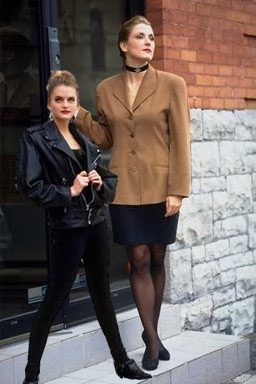

execution block done


In [35]:
orig_img = Image.open(path_original)
display(orig_img)
print("execution block done")

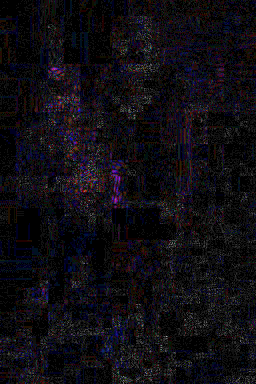

In [36]:
convert_to_ela_image(path_original,90)

In [25]:
X_f = []
print("execution block done")

execution block done


In [26]:
X_f.append(np.array(convert_to_ela_image(path_tampered,90).resize((60, 60))).flatten() / 255.0)
print("execution block done")

execution block done


In [27]:
X_f = np.array(X_f)
print("execution block done")

execution block done


In [28]:
X_f = X_f.reshape(-1, 60, 60, 3)
print("execution block done")

execution block done


In [29]:
from keras.models import load_model
model = load_model('model/detector.h5')
print("execution block done")

execution block done


In [30]:
y_pred_test = model.predict(X_f)
y_pred_test = np.argmax(y_pred_test,axis = 1)
print("execution block done")

execution block done


In [183]:
print(y_pred_test) #getting predicted class label as 0 or 1 where 0 means original and 1 means tamper image and in below 
#output the predicted class label is in square bracket as 1 

[0]
